## 프로젝트: 더 멋진 번역기 만들기

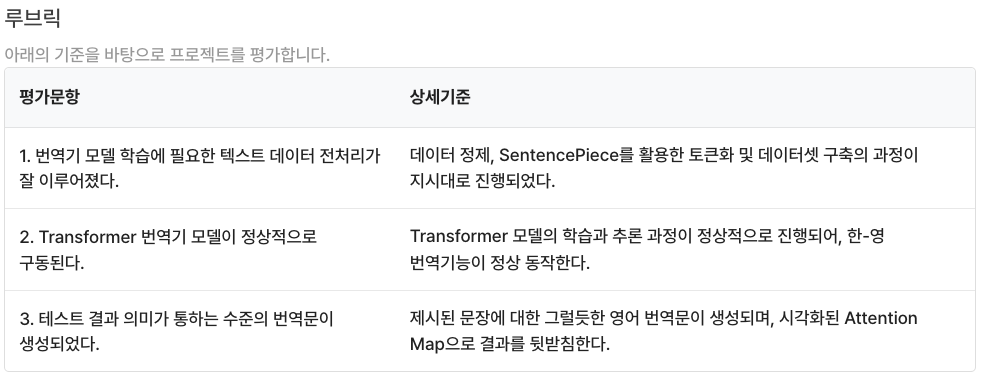

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm    # tqdm
import random
import numpy as np
import re
%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

import tensorflow as tf
import numpy
import os

print(tf.__version__)
print(np.__version__)
print(mpl.__version__)

2.6.0
1.21.4
3.4.3


## Step 1. 데이터 다운로드 (클라우드 유저용)

In [2]:
# ln -s ~/data ~/aiffel/transformer/data

## Step 2. 데이터 정제 및 토큰화

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [4]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(list(zip(kor,eng))))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [5]:
kor_corpus = []
eng_corpus = []
for k,e in cleaned_corpus : 
    kor_corpus.append(k) 
    eng_corpus.append(e)

In [6]:
# 데이터 확인하기, 최대 문장 길이, 최소 문장 길이, 평균 길이
lan = {'kor':{'min_len':0, 'max_len' : 0, 'sum_len':0}, 'eng':{'min_len':0, 'max_len' : 0, 'sum_len':0}}

for i, lang in zip(['kor','eng'],[kor_corpus, eng_corpus]) :
    for sen in lang :
        length = len(sen.split())
        if lan[i]['min_len'] > length : lan[i]['min_len'] = length
        if lan[i]['max_len'] < length : lan[i]['max_len'] =  length
        lan[i]['sum_len'] += length
    
    print(i)
    print('min :', lan[i]['min_len'])
    print('max :', lan[i]['max_len'])
    print('ave :', lan[i]['sum_len']//len(lang))
    print()

kor
min : 0
max : 82
ave : 14

eng
min : 0
max : 90
ave : 22



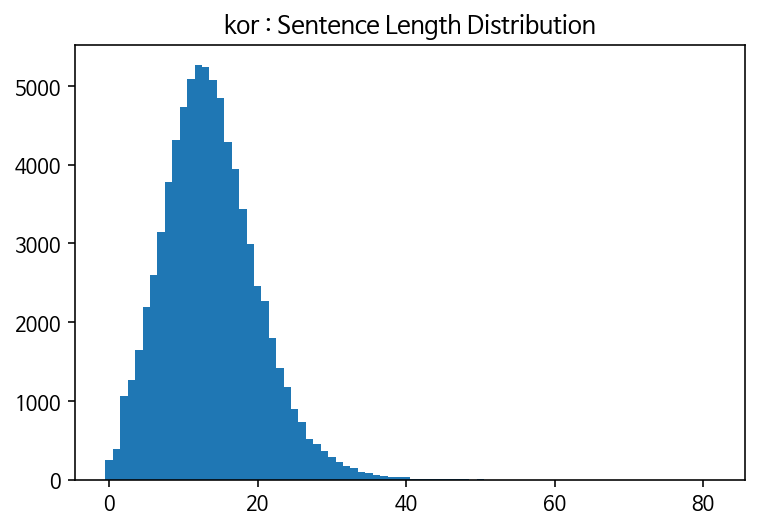

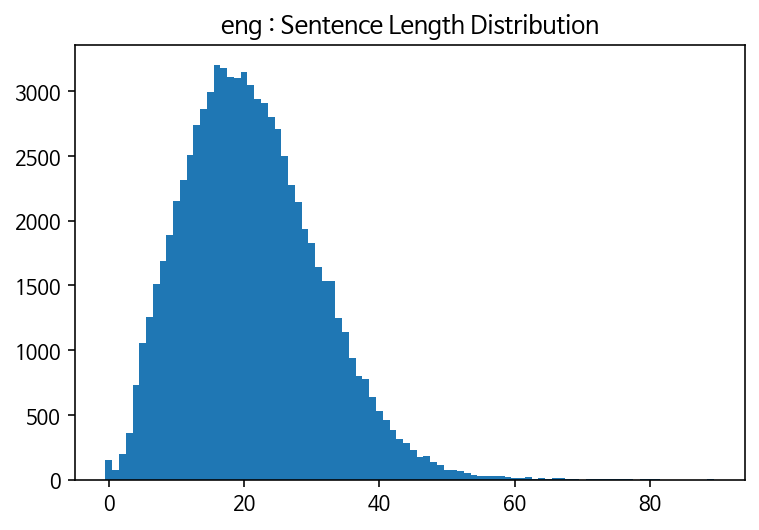

In [7]:
#문장 길이별로 행렬 값 채우기
for i,lang in zip(['kor','eng'],[kor_corpus, eng_corpus]) :
    sentence_length = np.zeros((lan[i]['max_len']), dtype=int)
    
    for sen in lang :
        sentence_length[len(sen.split())-1] += 1

    #분포 그려보기
    plt.bar(range(lan[i]['max_len']), sentence_length, width=1.0)
    plt.title(f"{i} : Sentence Length Distribution")
    plt.show()


In [348]:
def preprocess_sentence(sentence, kor=False):
    if kor :
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) 
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z!.,?]+", " ", sentence)

    else :
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z.,!?]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [111]:
import sentencepiece as spm
import os

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    # Training corpus into SentencePiece
    
    temp_file = os.getenv('HOME')+f'/aiffel/project_folder/tokenizer/{lang}_spm.train.ko.temp'

    with open(temp_file, 'w') as f:
        for row in corpus: 
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train( 
        f"--input={temp_file} --model_prefix={lang}_spm --vocab_size={vocab_size + 4}" + 
        " --model_type=unigram" +
        f" --pad_id={pad_id}" +#--pad_piece=[PAD]" + # pad
        f" --unk_id={unk_id}" +#--unk_piece=[UNK]" + # unknown
        f" --bos_id={bos_id}" +#--bos_piece=[BOS]" + # begin of sequence
        f" --eos_id={eos_id}" )#--eos_piece=[EOS]" ) # end of sequence
#         " --user_defined_symbols=[START],[END]") # 사용자 정의 토큰
    
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{lang}_spm.model')
    
    return tokenizer

In [112]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair
    kor_corpus.append(preprocess_sentence(k, s_token=False, e_token=False, kor=True))
    eng_corpus.append(preprocess_sentence(e, s_token=True, e_token=True, kor=False))

In [113]:
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")

In [114]:
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [359]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

In [360]:
# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    tgt = en_tokenizer.encode_as_ids(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50 :
        src_corpus.append(src)
        tgt_corpus.append(tgt)

  0%|          | 0/78968 [00:00<?, ?it/s]

In [361]:
print(ko_tokenizer.decode(src_corpus[0]))
print(en_tokenizer.decode(tgt_corpus[0]))

한국에 천만 달러 이상을 투자하겠다고 약속하면 김 전대통령 자신이 개인적으로 해외 CEO들을 만났다 .
kim himself met personally with foreign ceos as long as they were committed to investing more than million here .


In [362]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [363]:
print(enc_train.shape)
print(dec_train.shape)

(72102, 50)
(72102, 50)


## Step 3. 모델 설계

### 1. 2 Layer Transformer

In [364]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [365]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [366]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


In [367]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

슝=3


In [368]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3
슝=3


In [369]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [370]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # returns true if value is equal to 0; tf cast is just another way to transform tensors into designated dtype
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask) # returns max value between two

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1]) # why two? because of two multihead?
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


In [371]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 2. Learning Rate Scheduler and Adam Optimizer

In [372]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [373]:
d_model = 512

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 3. Loss 한수 정의

In [445]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4. Train_step

In [446]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [447]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = d_model * 4
src_vocab_size = ko_tokenizer.get_piece_size()
tgt_vocab_size = en_tokenizer.get_piece_size()
pos_len = d_model
dropout= 0.5

transformer = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout, shared=True)

In [448]:
# !rm -rf tf_ckpts2

In [449]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts2', max_to_keep=3)

In [450]:
def train_and_checkpoint(transformer, manager, EPOCH = 2, BATCH_SIZE = 64):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")

    
    examples = ['오바마는 대통령이다.',
                '시민들은 도시 속에 산다.',
                '커피는 필요 없다.',
                '일곱 명의 사망자가 발생했다.']
    
    for epoch in range(EPOCH):
        ckpt.step.assign_add(1)
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)    # tqdm

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(
                                    enc_train[idx:idx+BATCH_SIZE],
                                    dec_train[idx:idx+BATCH_SIZE,:-1],
                                    transformer,
                                    optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

            
        for j in examples :
            translate(j, transformer, ko_tokenizer, en_tokenizer)
            
        if int(ckpt.step) % 2 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))


### 5. Train

In [451]:
# Attention 시각화 함수
# visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [452]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence, kor=True)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [453]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [455]:
train_and_checkpoint(transformer, manager, EPOCH = 10, BATCH_SIZE = 64)

Initializing from scratch.


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a good campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a larger .
Input: 커피는 필요 없다.
Predicted translation: if you don t know .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .
Saved checkpoint for step 2: ./tf_ckpts2/ckpt-1


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban area is the city of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not enough to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll at .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obama president is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are a larger place .
Input: 커피는 필요 없다.
Predicted translation: no one wants to be used .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll from .
Saved checkpoint for step 4: ./tf_ckpts2/ckpt-2


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban city is a place .
Input: 커피는 필요 없다.
Predicted translation: no one does not need to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the u . s .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is in the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were forced to cut the city .
Input: 커피는 필요 없다.
Predicted translation: no one thing is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the karachi killed .
Saved checkpoint for step 6: ./tf_ckpts2/ckpt-3


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were driven by the city .
Input: 커피는 필요 없다.
Predicted translation: no need for any coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported monday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president of the obama presidency .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were displaying in the city .
Input: 커피는 필요 없다.
Predicted translation: nobody needs to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday , said a knew monday .
Saved checkpoint for step 8: ./tf_ckpts2/ckpt-4


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is president of the obama presidency .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were forced to grow .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed monday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the president of obama s presidential running .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were driven by their place .
Input: 커피는 필요 없다.
Predicted translation: never any entire coffee , nor any coffee legs is required to address . no coffee is to be more coffee forty .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed monday .
Saved checkpoint for step 10: ./tf_ckpts2/ckpt-5


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is a president of obama s he s obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they public cities just over they were celebrating rivers .
Input: 커피는 필요 없다.
Predicted translation: no need to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the university of seven people monday with a gun in the university of .


In [459]:
train_and_checkpoint(transformer, manager, EPOCH = 6, BATCH_SIZE = 64)

Restored from ./tf_ckpts2/ckpt-7


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is chavez .
Input: 시민들은 도시 속에 산다.
Predicted translation: they aren those in the s .
Input: 커피는 필요 없다.
Predicted translation: no part of it needs to be a few never to be at for anything or for action .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilian death was killed monday night .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: that s the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were driven from the city .
Input: 커피는 필요 없다.
Predicted translation: no star list was necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven leeese soldier were killed monday .
Saved checkpoint for step 16: ./tf_ckpts2/ckpt-8


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is obama s shot president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were escape armed by the city .
Input: 커피는 필요 없다.
Predicted translation: no to deny nor coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is obama s shot , he s in his first country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they publicly takes signs and arm them .
Input: 커피는 필요 없다.
Predicted translation: no need to convoy was part of or .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nationals were killed monday .
Saved checkpoint for step 18: ./tf_ckpts2/ckpt-9


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first in his country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were army towns forgeting .
Input: 커피는 필요 없다.
Predicted translation: no need is part of it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven people were killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first in his obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they publicly army forces in the city were a m .
Input: 커피는 필요 없다.
Predicted translation: no alternative need to coffee , the list is no ordinary coffee demand for her to coffee , nor didn t need to be any or little or little or little bit more frequent .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and a seven people were killed .
Saved checkpoint for step 20: ./tf_ckpts2/ckpt-10


In [463]:
print('hyperparameters:')
print('-------------------')
print('(n_layers): ',n_layers)
print('(d_model): ',d_model)
print('(n_heads): ',n_heads)
print('(d_ff): ',d_ff)
print('(src_vocab_size): ',src_vocab_size)
print('(tgt_vocab_size): ',tgt_vocab_size)
print('(pos_len): ',pos_len)
print('(dropout): ',dropout)


print('training parameters:')
print('-------------------')
print('warmup stps : 40000')
print('batch size : 64')
print('epoch : ', ckpt.step.numpy()) 

hyperparameters:
-------------------
(n_layers):  2
(d_model):  512
(n_heads):  8
(d_ff):  2048
(src_vocab_size):  20004
(tgt_vocab_size):  20004
(pos_len):  512
(dropout):  0.5
training parameters:
-------------------
warmup stps : 40000
batch size : 64
epoch :  20


---
### 회고

결과는 6번째 epoch에서 결과가 실질적인 번역과 가장 가까운 것 같다. 

epoch이 늘어날 수록 조금 더 번역이 정확해지는 것 같지만, 매우 정확하지는 않지만, Rnn을 사용했을때보다는 훨씬 더 결과가 좋은 것은 분명하다.

vocab size, hyperparameter 튜닝 등이 더 미세하게 이루어지면 결과는 더 좋아질 수 있을 것 같고, beam search 등도 두현해서 결과를 알아보는 것도 좋은 학습 경험일 것 같다.

트랜스포머의 파워를 느낄 수 있었던 노드였다. 

구현하는 데 큰 어려움은 없었으나... wow... 디버깅하는 데 시간을 많이 쓴것 같다.

안정적으로 학습은 계속 되었었는데... 결과를 확인할때마다 이상한 문구가 "........" 또는 "i don t i don t i don t i don t i don t " 와 같은 문장을 뱉어냈다...

진짜 고생 끝에 버그는 'evaluate' 함수의 'preprocessing' 함수를 위에서 다시 정의한 것을 놓치고 있었으니... input이 계속 이상한 값만 들어갔었던 것이다. 이것을 해결할려고 하루종일 붙들고 있었다... 그래도 힘겹게 해결을 해서 성취감도 업되고 어디서 실수를 내가 하고 있었는지 확실하게 배울 수 있었다.

---